In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import copy

In [2]:
import os


# Common  columns : Crop,Year


def preprocess_data(df):

    df.drop(
        axis=1,
        columns=[
            "districtcode",
            "statename",
            "statecode",
            "year",
            "crop",
            "districtname",
        ],
        inplace=True,
    )

    numerical_features = [
        "area1000hectares",
        "production1000tonnes",
        "irrigatedarea1000hectares",
        "nitrogenconsumptiontonnes",
        "phosphateconsumptiontonnes",
        "potashconsumptiontonnes",
        "total_rainfall",
        "average_rainfall",
        "salinity_alkalinity_percent",
        "unirrigatedarea1000hecatres",
    ]

    df["unirrigatedarea1000hecatres"] = (
        df["area1000hectares"] - df["irrigatedarea1000hectares"] + 1
    )

    df["irrigatedarea1000hectares"] = df["irrigatedarea1000hectares"] + 1

    df["salinity_alkalinity_percent"] = df["salinity_alkalinity_percent"] + 1

    numerical_transformer = Pipeline(
        steps=[("log", FunctionTransformer(np.log, validate=True)),
            #    ("minmax",StandardScaler())
               ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
        ]
    )

    X_df = pd.DataFrame(preprocessor.fit_transform(df), columns=numerical_features)

    output_file = "output.txt"
    with open(output_file, "w") as f:
        for i in X_df.iloc[0].items():

            f.write(str(i))
            f.write("\n")

    X = X_df.drop(axis=1, columns=["production1000tonnes"])
    print(X.describe())
    Y = X_df["production1000tonnes"]
    return X, Y


path_to_dataset = "Dataset/Task2Summary.csv"
df = pd.read_csv(path_to_dataset)


X_copy, Y_Copy = preprocess_data(df)
X, Y = torch.tensor(X_copy.to_numpy()), torch.tensor(Y_Copy.to_numpy())

       area1000hectares  irrigatedarea1000hectares  nitrogenconsumptiontonnes  \
count        255.000000                 255.000000                 255.000000   
mean           2.814935                   0.912635                  10.419594   
std            1.739210                   0.868367                   1.347837   
min           -3.506558                   0.000000                   4.317488   
25%            1.911740                   0.022735                  10.022158   
50%            3.109061                   0.731887                  10.751671   
75%            4.087392                   1.595234                  11.271286   
max            4.933142                   2.378550                  11.998810   

       phosphateconsumptiontonnes  potashconsumptiontonnes  total_rainfall  \
count                  255.000000               255.000000      255.000000   
mean                     9.468898                 7.982889        6.548398   
std                      1.409616   

In [3]:
class OLS(nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_features = None
        self.weights = None
        self.bias = None

    def forward(self, X):
        if self.num_features == None:
            raise LookupError("Train the OLS First :)")

        X = (X - X.mean(dim=0, keepdim=True)) / X.std(dim=0, keepdim=True)
        return torch.matmul(X, self.weights) + self.bias

    def calculate_statistics(self, y_prime: torch.tensor, y: torch.tensor):
        SST = ((y - y.mean()) ** 2).sum()

        SSR = ((y_prime - y.mean()) ** 2).sum()

        SSE = ((y_prime - y) ** 2).sum()

        EXPECTEDVALUE_U = (y - y_prime).sum()

        R2 = 1 - (SSE / SST)

        n = y.shape[0]
        p = self.num_features  # exclude bias
        adj_R2 = 1 - ((1 - R2) * (n - 1)) / (n - p - 1)

        print(
            f"Sum of squared Terms {SST.item():.4f}\nSum of squared errors {SSE.item():.4f} \nRegression sum of squares {SSR.item():.4f} \nExpected value of U {EXPECTEDVALUE_U.item():.4f} \nR2 {R2} \nadjustedR2 {adj_R2}"
        )
        return SSR, SSE, SST

    def fit(self, dataset):

        # Only accepts full batch

        X, Y = dataset
        print(Y.min())

        X_augmented = torch.cat((torch.ones(X.shape[0], 1), X), dim=1)
        X_t = X_augmented.t()  # Transpose of X'

        w = torch.linalg.inv(X_t @ X_augmented) @ X_t @ Y

        self.weights = nn.Parameter(w[1:].reshape(-1, 1))
        self.bias = nn.Parameter(w[0].reshape(1, 1))
        self.num_features = self.weights.shape[0]
        print(f"Trained OLS for {self.num_features} features")
        self.calculate_statistics(self(X), Y)

In [4]:
model = OLS() 
model.fit((X,Y))

tensor(-3.9120, dtype=torch.float64)
Trained OLS for 9 features
Sum of squared Terms 623.2786
Sum of squared errors 1129687.4365 
Regression sum of squares 3806.8682 
Expected value of U 244983.9426 
R2 -1811.4920330845107 
adjustedR2 -1878.0733730753702


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   crop                         255 non-null    object 
 1   area1000hectares             255 non-null    float64
 2   production1000tonnes         255 non-null    float64
 3   irrigatedarea1000hectares    255 non-null    float64
 4   districtcode                 255 non-null    int64  
 5   year                         255 non-null    int64  
 6   statecode                    255 non-null    int64  
 7   statename                    255 non-null    object 
 8   nitrogenconsumptiontonnes    255 non-null    float64
 9   phosphateconsumptiontonnes   255 non-null    float64
 10  potashconsumptiontonnes      255 non-null    float64
 11  districtname                 255 non-null    object 
 12  total_rainfall               255 non-null    float64
 13  averag

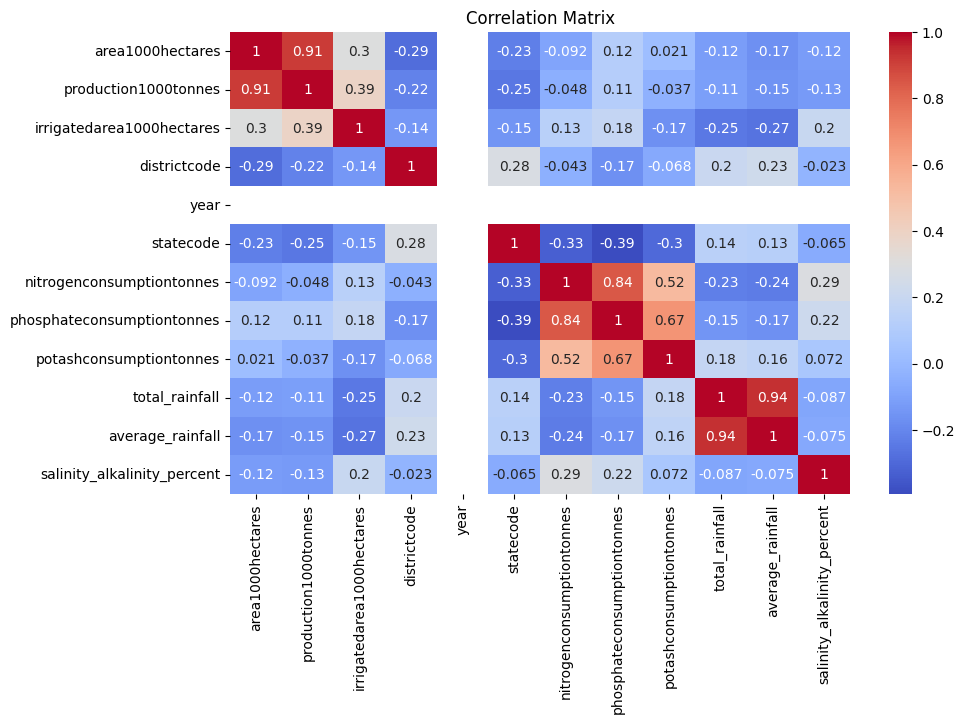

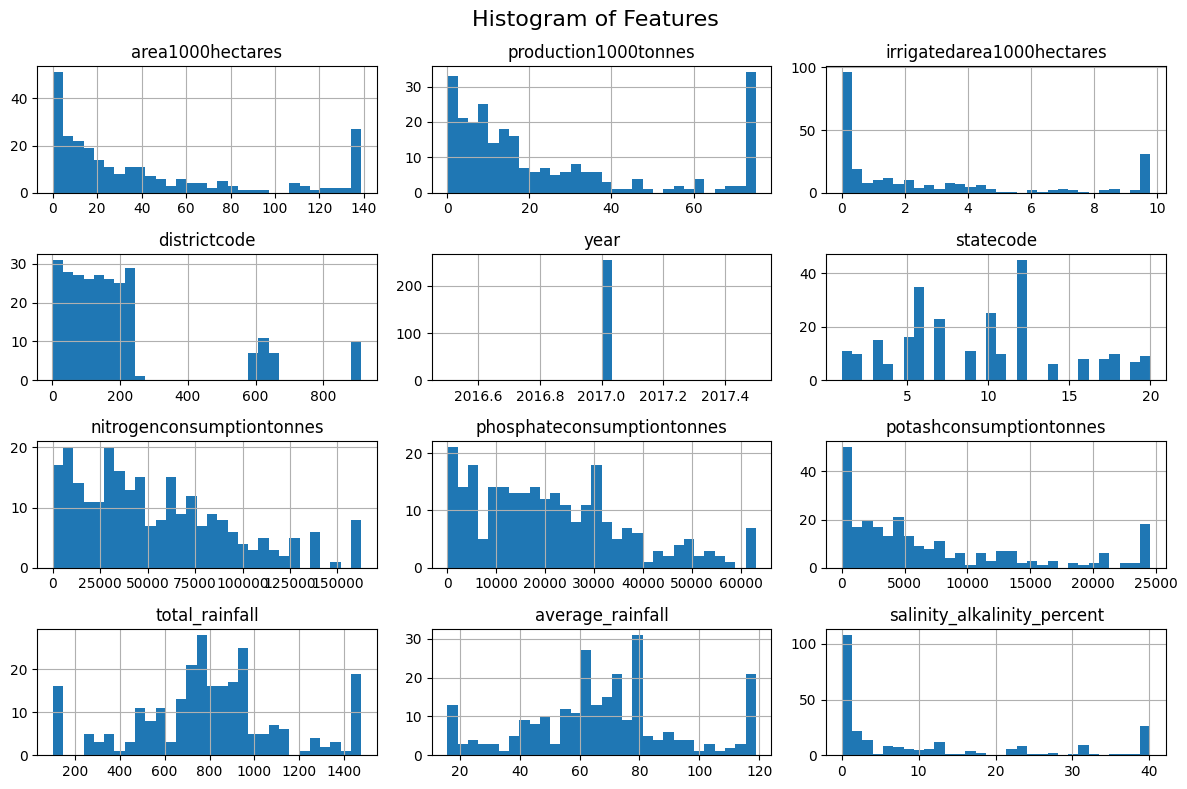

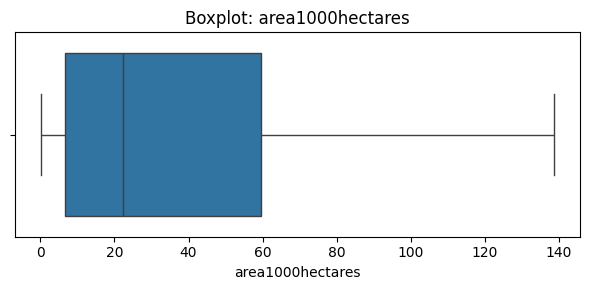

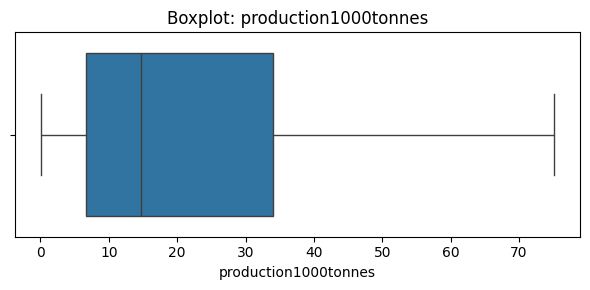

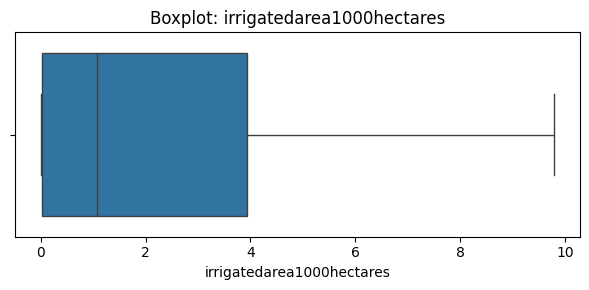

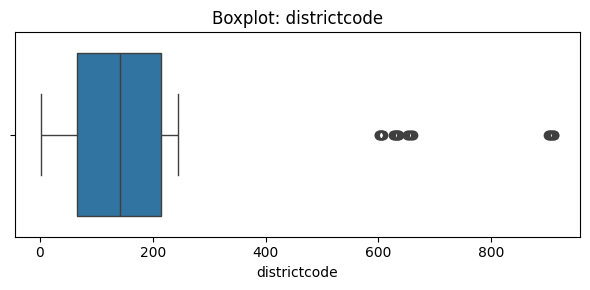

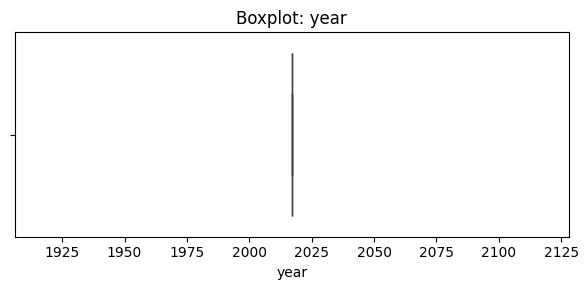

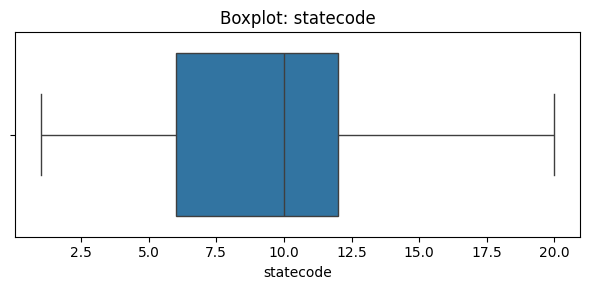

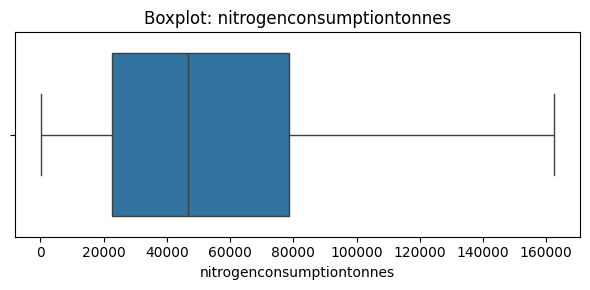

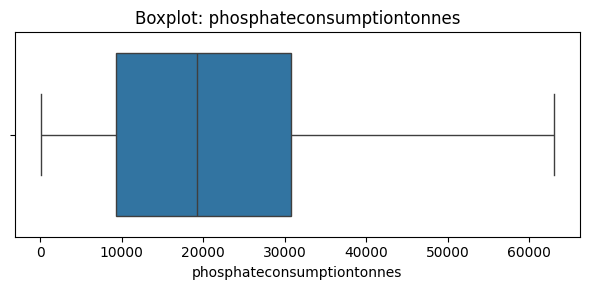

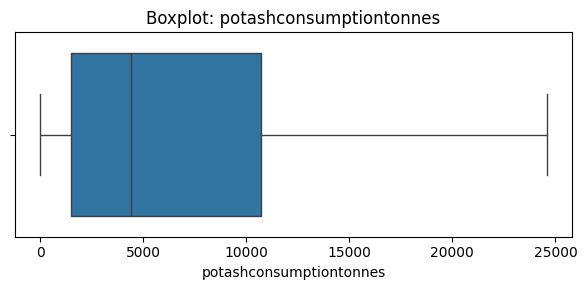

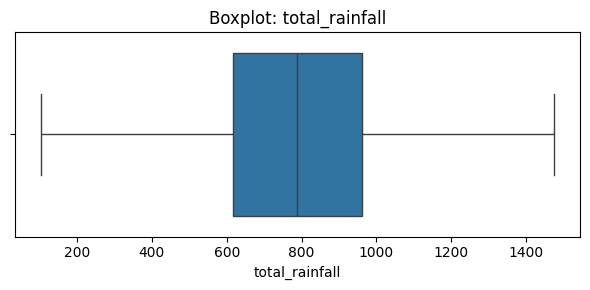

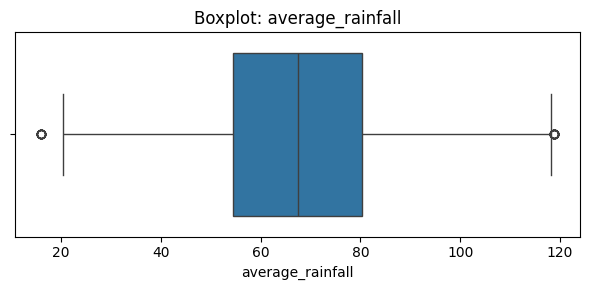

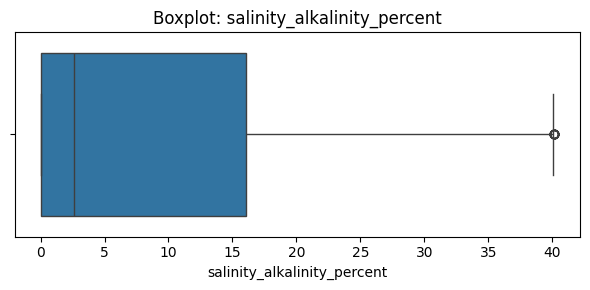

In [5]:
# This is for EDA

FILE_NAME = "Dataset/Task2Summary.csv"

df = pd.read_csv(FILE_NAME)


print("Dataset Info:")
print(df.info())

print("Summary Statistics:")
print(df.describe())

print("Missing Values:")
print(df.isnull().sum())

print("Duplicate Rows:", df.duplicated().sum())

if "target" in df.columns:
    print("Target Distribution:")
    print(df["target"].value_counts())
    sns.countplot(data=df, x="target")
    plt.title("Target Class Distribution")
    plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

df.hist(figsize=(12, 8), bins=30)
plt.suptitle("Histogram of Features", fontsize=16)
plt.tight_layout()
plt.show()

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()


# cat_cols = df.select_dtypes(include="object").columns.tolist()
# for col in cat_cols:
#     print(f"Value Counts for {col}:")
#     print(df[col].value_counts())
#     sns.countplot(data=df, x=col)
#     plt.title(f"Distribution of {col}")
#     plt.xticks(rotation=45)
#     plt.show()